In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install transformers
!pip install datasets
!pip install pytorch_pretrained_bert

!pip install rouge/requirements.txt
!pip install rouge-score

     |████████████████████████████████| 3.3 MB 12.6 MB/s 
     |████████████████████████████████| 596 kB 43.8 MB/s 
     |████████████████████████████████| 895 kB 37.9 MB/s 
     |████████████████████████████████| 3.3 MB 37.8 MB/s 
     |████████████████████████████████| 61 kB 515 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 298 kB 12.4 MB/s 
     |████████████████████████████████| 132 kB 50.6 MB/s 
     |████████████████████████████████| 1.1 MB 47.9 MB/s 
     |████████████████████████████████| 243 kB 47.6 MB/s 
     |████████████████████████████████| 192 kB 48.5 MB/s 
     |████████████████████████████████| 271 kB 50.9 MB/s 
     |████████████████████████████████| 160 kB 54.5 MB/s 
     |████████████████████████████████| 123 kB 12.2 MB/s 
     |████████████████████████████████| 131 kB 47.4 MB/s 
     |████████████████████████████████| 8

In [3]:
%cd '/content/drive/MyDrive/CS685/'

/content/drive/MyDrive/CS685


In [4]:
import os
import time
# from google.colab import drive

import json
import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

from transformers import AutoModelForCausalLM, AutoTokenizer, AdamW, GPT2LMHeadModel, \
GPT2DoubleHeadsModel, GPT2TokenizerFast, GPT2Config, BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

from datasets import load_dataset
from helper import format_time, rouge
from data import GPT2Dataset, preprocessing, split_data
from plots import loss_curves

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [6]:
covid_dialog = load_dataset("covid_qa_ucsd", "en", data_dir="./" )
md_df = pd.read_pickle("./med_dialogue_sample.pickle")
print(covid_dialog)

Downloading:   0%|          | 0.00/3.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805 [00:00<?, ?B/s]

Using custom data configuration en-data_dir=.%2F


0 examples [00:00, ? examples/s]

Dataset covid_qa_ucsd downloaded and prepared to /root/.cache/huggingface/datasets/covid_qa_ucsd/en-data_dir=.%2F/1.0.0/2a15b6e8fdc7cee91951d8f20ac2b26ede79fbef988919fbde22dbb97bf4df81. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['dialogue_id', 'dialogue_url', 'dialogue_turns'],
        num_rows: 572
    })
})


In [7]:
cd_df = covid_dialog['train'].to_pandas()
md_df.drop(columns=["file_name"])
md_df = md_df[0:570]
print(len(md_df))
md_df.head()

800


,file_name,dialogue_id,dialogue_url,dialogue_turns
0,/content/drive/MyDrive/CS685/Medical-Dialogue-...,699,https://www.healthcaremagic.com/questions/What...,"{'speaker': [0, 1], 'utterance': ['What causes..."
1,/content/drive/MyDrive/CS685/Medical-Dialogue-...,1380,https://www.healthcaremagic.com/questions/Coul...,"{'speaker': [0, 1], 'utterance': ['Could frequ..."
2,/content/drive/MyDrive/CS685/Medical-Dialogue-...,1574,https://www.healthcaremagic.com/questions/What...,"{'speaker': [0, 1], 'utterance': ['What can ca..."
3,/content/drive/MyDrive/CS685/Medical-Dialogue-...,2049,https://www.healthcaremagic.com/questions/Can-...,"{'speaker': [0, 1], 'utterance': ['Can someone..."
4,/content/drive/MyDrive/CS685/Medical-Dialogue-...,2239,https://www.healthcaremagic.com/questions/Can-...,"{'speaker': [0, 1], 'utterance': ['Can respira..."


In [8]:
combined = pd.concat([cd_df, md_df])
qa_df = preprocessing(combined)
text = qa_df.text.copy()
print(qa_df["encoder"][0])
print(qa_df["encoder"][1])
qa_df.head()

['<|patient|>I have cough with no travel history. Is this a symptom of Covid-19?Hello doctor, I get a cough for the last few days, which is heavy during night times. No raise in temperature but feeling tired with no travel history. No contact with any Covid-19 persons. It has been four to five days and has drunk a lot of Benadryl and took Paracetamol too. Doctors have shut the OP so do not know what to do? Please help. <|doctor|>']
['<|patient|>I have cough with no travel history. Is this a symptom of Covid-19?Hello doctor, I get a cough for the last few days, which is heavy during night times. No raise in temperature but feeling tired with no travel history. No contact with any Covid-19 persons. It has been four to five days and has drunk a lot of Benadryl and took Paracetamol too. Doctors have shut the OP so do not know what to do? Please help. <|doctor|>Hello, I understand your concern. I just have a few more questions.Does your cough has phlegm? Any other symptoms like difficulty b

/content/data.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_fields = np.transpose(np.array(all_fields).reshape((4, -1)))


,id,encoder,decoder,text
0,0,[<|patient|>I have cough with no travel histor...,"[Hello, I understand your concern. I just have...",[<|patient|>I have cough with no travel histor...
1,0,[<|patient|>I have cough with no travel histor...,"[Hi, I would recommend you take n-acetylcystei...",[<|patient|>I have cough with no travel histor...
2,1,[<|patient|>I have a little fever with no hist...,"[Hello, I can understand your concern.In my op...",[<|patient|>I have a little fever with no hist...
3,1,[<|patient|>I have a little fever with no hist...,"[Hi, yes, upload in this query only. I will se...",[<|patient|>I have a little fever with no hist...
4,1,[<|patient|>I have a little fever with no hist...,"[Hi, I can understand your concern. I have gon...",[<|patient|>I have a little fever with no hist...


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


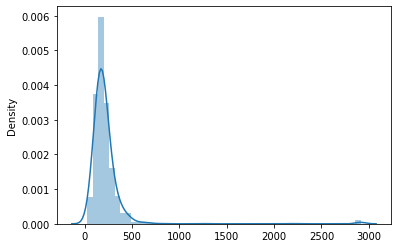

In [9]:
doc_lengths = []

for bio in text:
  
    # get rough token count distribution
    tokens = nltk.word_tokenize(bio[0])

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)
             

In [10]:
torch.cuda.empty_cache()

In [11]:
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
tokenizer.add_tokens(["<|patient|>", "<|doctor|>"], special_tokens=True)
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")


Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [12]:
batch_size = 2
tokenizer.pad_token = tokenizer.eos_token

unique_vals = qa_df.id[len(qa_df)-1]

# Split into training and validation sets
train_size = int(0.75 * unique_vals)
val_size = int(0.125 * unique_vals)
test_size = unique_vals - train_size - val_size

train_split, val_split, test_split = split_data(qa_df, [train_size, val_size, test_size])

train_split.reset_index(drop=True, inplace=True)
val_split.reset_index(drop=True, inplace=True)
test_split.reset_index(drop=True, inplace=True)

print(train_split.head())

print("length of dataset: " + str(unique_vals))
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

train_dataset = GPT2Dataset(train_split, tokenizer, max_length=768)
val_dataset = GPT2Dataset(val_split, tokenizer, max_length=768)
test_dataset = GPT2Dataset(test_split, tokenizer, max_length=768)

    id  ...                                               text
0  730  ...  [<|patient|>Mitral valve prolapse, taking naxi...
1  417  ...  [<|patient|>My throat is extremely scratchy an...
2  685  ...  [<|patient|>How to treat chronic cough in preg...
3  158  ...  [<|patient|>I am a little concerned that I may...
4  537  ...  [<|patient|>My 2year old Son has had a dry cou...

[5 rows x 4 columns]
length of dataset: 1371
1,096 training samples
  137 validation samples
  138 test samples


In [13]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [14]:
useCuda = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

cuda


In [15]:
# I'm not really doing anything with the config buheret
# configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
# model = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-small")
# model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
# if torch.cuda.is_available() and useCuda:
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [17]:
# some parameters I cooked up that work reasonably well
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100


In [18]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [19]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [20]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[5].to(device)
        b_labels = batch[5].to(device)
        b_masks = batch[6].to(device)
        model.zero_grad()        

        outputs = model(b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    # bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    min_length = 50,
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[5].to(device)
        b_labels = batch[5].to(device)
        b_masks = batch[6].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 1 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    548. Loss: 1.1703025102615356.   Elapsed: 0:01:37.
0: In fact he did use magic to do the magic magic thing he did on the Magic thing you did on Magic thing you did on magic thing you did in magicthing you did on Magic thing you did on Magic thing you did on Magic thing you did magic thing you did on Magic thing you did magic thing you did on magic thing you did on Magic thing you did on Magic thing you did magic thing you did on Magic Magic thing you did on magic thing you did on Magic thing you did magic things on Magic thing you did magic magic magic magic magic magic magic Magic magic magic magic Magic Magic magic magic magic magic magic magic magic magic Magic Magic magic Magic magic magic Magic Magic Magic Magic Magic magic magic Magic Magic Magic Magic Magic Magic Magic magic Magic magic Magic magic Magic Magic Magic Magic magic Magic magic magic Magic Magic magic Magic Magic Magic magic Magic Magic Magic Magic magic Magic Magic magic Magic Magic Magic Magic 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    548. Loss: 2.043696165084839.   Elapsed: 0:03:18.
0: .??.,?,,?,.??,?,.,.,,,,,,,,,,,,.,?,,?,,,,,,?,,,.,,,,,,,.,,,,,,,,,,,,,,?,,,,,,.,,?,,?,?,,,,,,,,.,,.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    548. Loss: 0.9843605160713196.   Elapsed: 0:04:57.
0: What causes difficulty breathing after breathing exercises after a morning run?I recently started running in an open air vent and I am a little concerned. I am not feeling good. What could this be?  Would you like to video or text chat with me? I am having difficulty breathing after breathing exercises and am a little concerned. I am a little concerned. I am not feeling good. What could this be?  Would you like to video or text chat with me?  Would you like to video or text chat with me?  Would you like to video or text chat with me?  Would you like to video or text chat?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    548. Loss: 0.5365815758705139.   Elapsed: 0:06:36.
0: ,.,..?,.?,.,.,.,?,??,,,.??,,.,,?,,.,?,?,,,,,,,??,?,,,?,.,,,.,?,,,,,,,,,,,,,,.,,,,,,,.,,,.?,,,,,,,,,,,,,,,,,,,,,,,,,,,?,,,,,,,,,,,,,,,,,,?,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    548. Loss: 0.6571518182754517.   Elapsed: 0:08:17.
0: How to treat my chest congestion while working out?HelloI can't even eat right after 5 days of working out. After that I get sick. So my Chest congestion is getting worse. It has been about an hour and a half before today. I feel like I am about to die. My chest congestion is not normal and I feel sick. It also says this was a long period of a time before being tested and the test was tested. So why would it be this is my chest congestion? Does my chest congestion get worse when I am in the gym?My chest congestion is just so bad right now. HI I am a doctor with a severe allergy. My concern is not what is happening but how to treat it as the allergy occurs at the moment.  Please help the respiratory infection of upper respiratory tract is not an issue.    The pain of my chest is because my body is hurting and I need to stop eating, this is not an allergic reaction to

  Average training loss: 1.40
  Training epoc

In [21]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats


,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.4,1.09,0:09:06,0:00:21


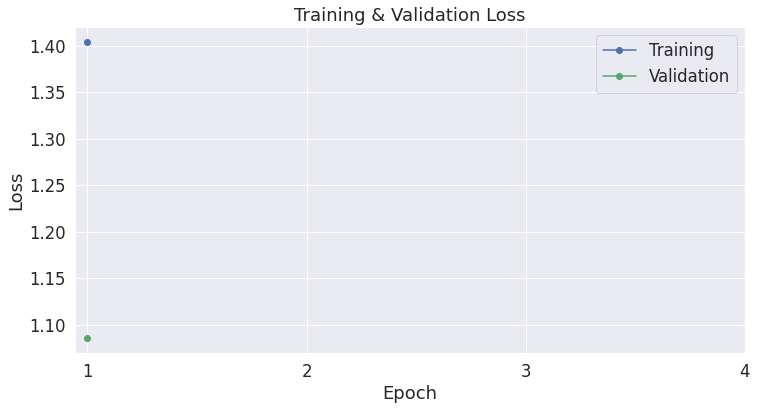

In [22]:
loss_curves(df_stats)

In [23]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [26]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './models/decoder/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./models/decoder/


('./models/decoder/tokenizer_config.json',
 './models/decoder/special_tokens_map.json',
 './models/decoder/vocab.json',
 './models/decoder/merges.txt',
 './models/decoder/added_tokens.json',
 './models/decoder/tokenizer.json')

In [29]:
tokenizer = AutoTokenizer.from_pretrained("models/decoder")
model = AutoModelForCausalLM.from_pretrained("models/decoder")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [30]:
model = model.to('cpu')
rougeL = []
rougeLsum = []
rouge1 = []
rouge2 = []

f = open('decoder.csv','w')
f.write("input, prediction, ground\n")

for i, encoder_input in enumerate(test_dataset.input_ids[0:5]):
    encoder_input = encoder_input[encoder_input != 50256]
    encoder_input = torch.reshape(encoder_input, (1, -1))

    predicted = model.generate(encoder_input, max_length=1000, min_length=50, return_dict=True)
    
    decoded_input = tokenizer.decode(encoder_input[0], skip_special_tokens=True)
    decoded_prediction = tokenizer.decode(predicted[:, encoder_input.shape[-1]:][0], skip_special_tokens=True)
    decoded_ground = tokenizer.decode(test_dataset.decoder_ids[i], skip_special_tokens=True)
    
    print("input: ")
    print(decoded_input)
    print("prediction: ")
    print(decoded_prediction)
    print("ground: ")
    print(decoded_ground)
    # print("How well did I answer the question? (See the five-point scale in the readme.)")
    # question_score = input("Answer: ")
    # print("Thanks! How fluent were my answers? (See the five-point scale in the readme.)")
    # fluency_score = input("Answer: ")
    print("\n")

    row = decoded_input + ", " + decoded_prediction + ", " + decoded_ground + "\n"
    f.write(row)
    
    rouge_dict = rouge(decoded_prediction, decoded_ground)
    rougeL.append(rouge_dict["rougeL"])
    rougeLsum.append(rouge_dict["rougeLsum"])
    rouge1.append(rouge_dict["rouge1"])
    rouge2.append(rouge_dict["rouge2"])

f.close()

avg_rougeL_p = sum([rougeL[i].precision for i in range(len(rougeL))])/len(rougeL)
avg_rougeL_r = sum([rougeL[i].recall for i in range(len(rougeL))])/len(rougeL)
avg_rougeL_f = sum([rougeL[i].fmeasure for i in range(len(rougeL))])/len(rougeL)

avg_rougeLsum_p = sum([rougeLsum[i].precision for i in range(len(rougeLsum))])/len(rougeLsum)
avg_rougeLsum_r = sum([rougeLsum[i].recall for i in range(len(rougeLsum))])/len(rougeLsum)
avg_rougeLsum_f = sum([rougeLsum[i].fmeasure for i in range(len(rougeLsum))])/len(rougeLsum)

avg_rouge1_p = sum([rouge1[i].precision for i in range(len(rouge1))])/len(rouge1)
avg_rouge1_r = sum([rouge1[i].recall for i in range(len(rouge1))])/len(rouge1)
avg_rouge1_f = sum([rouge1[i].fmeasure for i in range(len(rouge1))])/len(rouge1)

avg_rouge2_p = sum([rouge2[i].precision for i in range(len(rouge2))])/len(rouge2)
avg_rouge2_r = sum([rouge2[i].recall for i in range(len(rouge2))])/len(rouge2)
avg_rouge2_f = sum([rouge2[i].fmeasure for i in range(len(rouge2))])/len(rouge2)

print("RougeL - precision: " + str(avg_rougeL_p) + ", recall: " + str(avg_rougeL_r) + ", fmeasure: " + str(avg_rougeL_f))
print("RougeLsum - precision: " + str(avg_rougeLsum_r) + ", recall: " + str(avg_rougeLsum_r) + ", fmeasure: " + str(avg_rougeLsum_f))
print("Rouge1 - precision: " + str(avg_rouge1_p) + ", recall: " + str(avg_rouge1_r) + ", fmeasure: " + str(avg_rouge1_f))
print("Rouge2 - precision: " + str(avg_rouge2_p) + ", recall: " + str(avg_rouge2_r) + ", fmeasure: " + str(avg_rouge2_f))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
Asthma, gas pressure in upper chest, rib cage and shoulder areaI have gas pressure in my upper chest, rib cage and shoulder area. This pressure increases when my asthma acts up. I believe it is a result of inflammation, but cannot be sure. How might I go about fixing the problem. It is most definitely respiratory related, not digestive or related to my heart. 
prediction: 
Hi, I have a question. I have been in contact with someone who has had asthma for over a year. I have been in contact with him for over a year. I have not been able to get him to answer the question. I have been in contact with him. I have not been able to get him to answer the question. I have been in contact with someone who has had asthma for over a year. I have not been in contact with him. I have not been in contact with him.                                                                                                                                                                                      

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


input: 
What must I do if I have been in contact with a covid19 positive person?What must I do if I have been in contact with a covid19 positive person? 
prediction: 
In brief:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

KeyboardInterrupt: ignored

In [ ]:
model = model.to('cpu')
step = 0
while True:
    context = input(">> User:")
    if context == "I am done talking":
      print("DialoGPT: Ok bye bye")
      print("How well did I answer the question? (See the five-point scale in the readme.)")
      input("Answer: ")
      print("Thanks! How fluent were my answers? (See the five-point scale in the readme.)")
      input("Answer: ")
      break
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids1 = tokenizer(context, return_tensors='pt').input_ids

    # append the new user input tokens to the chat history
    bot_input_ids1 = torch.cat([chat_history_ids1, new_user_input_ids1], dim=-1) if step > 0 else new_user_input_ids1

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids1 = model.generate(bot_input_ids1, max_length=1000, return_dict=True)
    step += 1
    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids1[:, bot_input_ids1.shape[-1]:][0], skip_special_tokens=True)))

In [25]:
print(model.device)

print(bot_input_ids1.device)

# Can't be different

cpu


NameError: ignored